# Fitting Regression Models

In [1]:
# Import the modules made for feature imputation/engineering/selection
import sys
sys.path.insert(0,'..')
import FeatureEngineering_Module as fe
import Imputation_Module as imp
import Encoding_Module as ec

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
sns.set(style = "whitegrid")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [23]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import joblib

## Load data and set it up for modelling

In [3]:
train_df, test_df = imp.impute_data()
train = fe.FeatureEngineering(train_df)
test = fe.FeatureEngineering(test_df)

In [4]:
# Isolating the target feature and applying log transformation for normality
saleprice = train["SalePrice"]
Y = saleprice.apply(np.log)
X = train.drop("SalePrice", axis = 1)

In [5]:
X, test = fe.Dummify(X, test)

In [6]:
print("train shape: " + str(X.shape))
print("test shape: " + str(test.shape))

train shape: (1456, 173)
test shape: (1459, 173)


## Train/Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

## Multiple Linear Regression

In [8]:
ols = LinearRegression()

In [9]:
score = np.mean(cross_val_score(estimator = ols, X = X_train, y = y_train, cv = 10))
ols.fit(X_train, y_train)
pred = ols.predict(X_test)
RMSLE = (mean_squared_error(pred, y_test, squared = False))

print("CV R-square: " + str(score))
print("Train set R-Square: " + str(round(ols.score(X_train, y_train),5)))
print("Test set R-Square: " + str(round(ols.score(X_test, y_test),5)))
print("RMSLE: " + str(round(RMSLE, 5)))

CV R-square: 0.8919861623361921
Train set R-Square: 0.93247
Test set R-Square: 0.9136
RMSLE: 0.11428


In [12]:
import statsmodels.api as sm
features_add=sm.add_constant(X)
ols_result = sm.OLS(Y,features_add).fit().summary2()
ols_pval = ols_result.tables[1][ols_result.tables[1]['P>|t|'] < 0.05].round(4)[1:]

# ols_pval.reindex(ols_pval["Coef."].abs().sort_values(ascending = False).index)

Text(0, 0.5, 'Predicted Value')

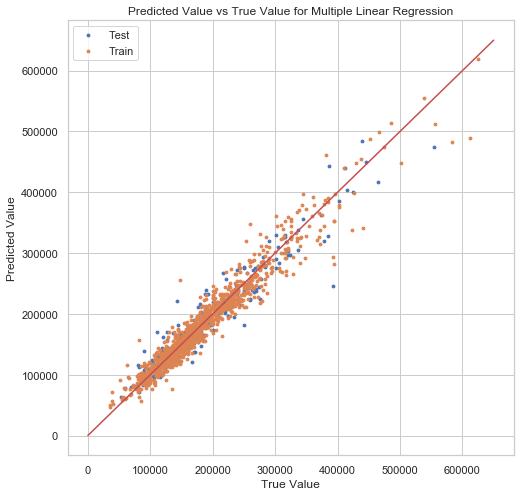

In [13]:
plt.figure(figsize=(8,8))
plt.scatter(x = np.exp(y_test), y = np.exp(pred), s = 8, label = "Test")
plt.scatter(x = np.exp(y_train), y = np.exp(ols.predict(X_train)), s = 8, label = "Train")
plt.plot([0,650000],[0,650000], color = "r")
plt.legend(loc = 0)
plt.title("Predicted Value vs True Value for Multiple Linear Regression")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

## Ridge Regression

In [14]:
ridge = Ridge(normalize = True)

In [15]:
alpha_100 = np.logspace(-5,5, 100)
coef = []
for i in alpha_100:
    ridge.set_params(alpha = i)
    ridge.fit(X, Y)
    coef.append(ridge.coef_)

Text(0, 0.5, 'coefficients')

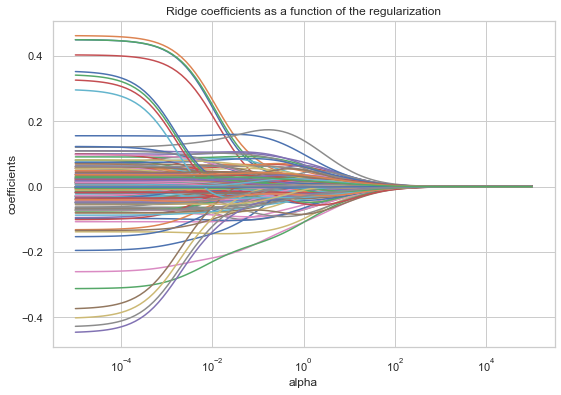

In [16]:
df_coef = pd.DataFrame(coef, index=alpha_100)
title = 'Ridge coefficients as a function of the regularization'
axes = df_coef.plot(logx = True, title=title, legend = False)
axes.set_xlabel('alpha')
axes.set_ylabel('coefficients')

In [18]:
ridgecv = RidgeCV(alphas = alpha_100, normalize = True, cv = 10)

In [19]:
ridgecv.fit(X_train, y_train)
score = ridgecv.score(X_train, y_train)
alpha = ridgecv.alpha_
pred_ridge = ridgecv.predict(X_test)
RMSLE = (mean_squared_error(pred_ridge, y_test, squared = False))

print("Mean R-square with 10 Fold Cross Validation: " + str(round(score, 5)))
print("Best Lambda: " + str(alpha))
print("RMSLE: " + str(round(RMSLE, 5)))

Mean R-square with 10 Fold Cross Validation: 0.93119
Best Lambda: 0.008497534359086439
RMSLE: 0.11202


In [24]:
# pickle the parameter
# joblib.dump(ridgecv, "ridge_param.pkl")

['ridge_param.pkl']

In [26]:
ridgecv_coef = pd.DataFrame(ridgecv.coef_, index = X.columns).rename(columns = {0:"Coef."})
ridgecv_coef = ridgecv_coef.reindex(ridgecv_coef["Coef."].abs().sort_values(ascending = False).index)
ridgecv_coef.head(10)

,Coef.
MSZoning_RH,0.284247
MSZoning_RL,0.275686
MSZoning_FV,0.266751
ExterCond_Po,-0.246633
MSZoning_RM,0.236996
Exterior1st_BrkComm,-0.236941
Foundation_Wood,-0.226113
GarageQual_Fa,-0.165342
HouseStyle_2.5Fin,-0.155058
OverallQual_EX,0.140186


Text(0, 0.5, 'Predicted Value')

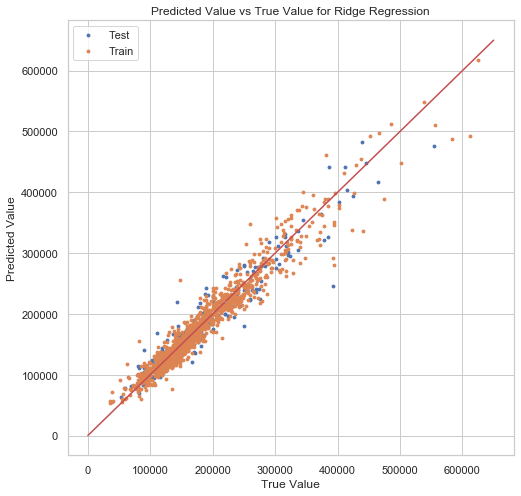

In [40]:
plt.figure(figsize=(8,8))
plt.scatter(x = np.exp(y_test), y = np.exp(pred_ridge), s = 8, label = "Test")
plt.scatter(x = np.exp(y_train), y = np.exp(ridgecv.predict(X_train)), s = 8, label = "Train")
plt.plot([0,650000],[0,650000], color = "r")
plt.legend(loc = 0)
plt.title("Predicted Value vs True Value for Ridge Regression")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

## Lasso Regression

In [28]:
lasso = Lasso(normalize = True, max_iter = 10000)

In [29]:
alpha_100 = np.logspace(-7,-1, 100)
coef = []
for i in alpha_100:
    lasso.set_params(alpha = i)
    lasso.fit(X, Y)
    coef.append(lasso.coef_)

Text(0, 0.5, 'coefficients')

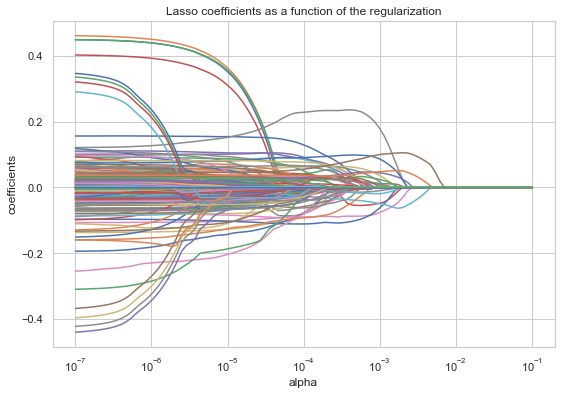

In [30]:
df_coef = pd.DataFrame(coef, index=alpha_100)
title = 'Lasso coefficients as a function of the regularization'
axes = df_coef.plot(logx = True, title=title, legend = False)
axes.set_xlabel('alpha')
axes.set_ylabel('coefficients')

In [31]:
lassocv = LassoCV(alphas = alpha_100, normalize = True, cv = 10, max_iter = 10000)

In [42]:
lassocv.fit(X_train, y_train)
score = lassocv.score(X_train, y_train)
alpha = lassocv.alpha_
pred_lasso = lassocv.predict(X_test)
RMSLE = (mean_squared_error(y_test, pred_lasso, squared = False))

print("Mean R-square with 10 Fold Cross Validation: " + str(round(score, 5)))
print("Best Lambda: " + str(alpha))
print("RMSLE: " + str(round(RMSLE, 5)))

Mean R-square with 10 Fold Cross Validation: 0.9296
Best Lambda: 2.310129700083158e-05
RMSLE: 0.11027


In [34]:
# pickle the parameter
# joblib.dump(lassocv, "lasso_param.pkl")

['lasso_param.pkl']

In [35]:
lassocv_coef = pd.DataFrame(lassocv.coef_, index = X.columns).rename(columns = {0:"Coef."})
lassocv_imp = lassocv_coef[lassocv_coef["Coef."] > 0]
lassocv_imp = ridgecv_coef.reindex(ridgecv_coef["Coef."].abs().sort_values(ascending = False).index)
lassocv_imp.head(10)

,Coef.
MSZoning_RH,0.284247
MSZoning_RL,0.275686
MSZoning_FV,0.266751
ExterCond_Po,-0.246633
MSZoning_RM,0.236996
Exterior1st_BrkComm,-0.236941
Foundation_Wood,-0.226113
GarageQual_Fa,-0.165342
HouseStyle_2.5Fin,-0.155058
OverallQual_EX,0.140186


Text(0, 0.5, 'Predicted Value')

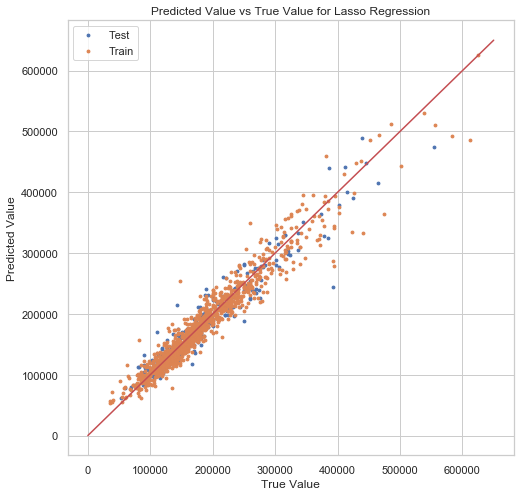

In [43]:
plt.figure(figsize=(8,8))
plt.scatter(x = np.exp(y_test), y = np.exp(pred_lasso), s = 8, label = "Test")
plt.scatter(x = np.exp(y_train), y = np.exp(lassocv.predict(X_train)), s = 8, label = "Train")
plt.plot([0,650000],[0,650000], color = "r")
plt.legend(loc = 0)
plt.title("Predicted Value vs True Value for Lasso Regression")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

### Dropping Features with Coef = 0 with LassoCV and fitting MLR again

In [37]:
imp_cols = lassocv_coef[lassocv_coef["Coef."] > 0].index.tolist()
print("Shape of Data set with only important features: " + str(X[imp_cols].shape))

Shape of Data set with only important features: (1456, 70)


In [39]:
score = np.mean(cross_val_score(estimator = ols, X = X_train[imp_cols], y = y_train, cv = 10))
ols.fit(X_train[imp_cols], y_train)
pred_lcv = ols.predict(X_test[imp_cols])
RMSLE = (mean_squared_error(pred_lcv, y_test, squared = False))

print("CV R-square: " + str(score))
print("Train set R-Square: " + str(round(ols.score(X_train[imp_cols], y_train),5)))
print("Test set R-Square: " + str(round(ols.score(X_test[imp_cols], y_test),5)))
print("RMSLE: " + str(round(RMSLE, 5)))

CV R-square: 0.8878898098676998
Train set R-Square: 0.90735
Test set R-Square: 0.89169
RMSLE: 0.12795
